<a href="https://colab.research.google.com/github/bcwein/1RT705APML-Project/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Question 5 A first Gibbs sampler

Want to estimate posterior

$$
p(s_1, s_2|y=1)
$$

And we know that $p(y=1)$ = $p(t>0)$.

so

$$
p(s_1, s_2|t>0)
$$

# Project in APML

Contributors:

- Bjørn Christian Weinbach
- Emil
- Markus

In [1]:
import numpy as np
import scipy.stats
import matplotlib.pyplot
import seaborn as sns
sns.set_style('darkgrid')
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix

# Save figures - Set to true if you want to reproduce figures.
save = False

def gibbsSampler(L, mu_s, sigma_s, burn=0):
    L = L

    # Initial Chain of values
    s1 = np.zeros(L)
    s2 = np.zeros(L)
    t = np.zeros(L)
    s1[0] = mu_s[0]
    s2[0] = mu_s[1]
    t[0] = 1

    # Hyperparameters
    sigma_ts = (25/3)**2

    def corr1(sigmaa, sigmaba, mua, xb): 
        A = np.array([1, -1])
        sigmaab = np.linalg.inv(np.linalg.inv(sigmaa) + np.outer(A.T, A)*sigmaba**-1)
        muab = sigmaab@(np.linalg.inv(sigmaa)@mua + A.T*sigmaba**-1*xb)
        return sigmaab, muab

    for l in range(L-1):
        # Sample S
        sigma_st, mu_st = corr1(sigma_s, sigma_ts, mu_s, t[l])
        s1[l+1], s2[l+1] = scipy.stats.multivariate_normal.rvs(mean=mu_st, cov=sigma_st)

        # Sample T
        smean = s1[l] - s2[l]
        a_scaled, b_scaled = (0 - (smean)) / sigma_ts, (np.inf - (smean)) / sigma_ts
        t[l+1] = scipy.stats.truncnorm.rvs(a_scaled, b_scaled, loc=smean, scale=np.sqrt(sigma_ts))
    return s1[burn:], s2[burn:], t[burn:]

In [2]:
# Samples
L = 1000
burn = 0
# Priors
sigma_s = np.array([[(25/3)**2, 0], [0, (25/3)**2]])
mu_s = np.array([25, 25])

# Sample
s1, s2, t = gibbsSampler(L+burn, mu_s, sigma_s, burn)

In [3]:
experiment = pd.DataFrame(
    {
        "s1": s1,
        "s2": s2,
        "t": t
    }
)

30.858717400334193

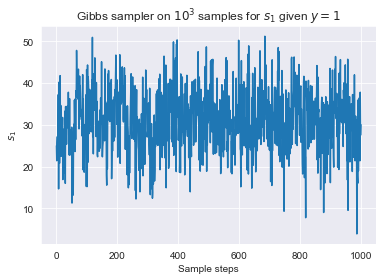

In [4]:
plt.plot(s1)
plt.title("Gibbs sampler on $10^3$ samples for $s_1$ given $y=1$")
plt.ylabel("$s_1$")
plt.xlabel("Sample steps")
if(save):
    plt.savefig("s1traceplotwithoutburnin.png")
np.mean(s1)

30.858717400334193

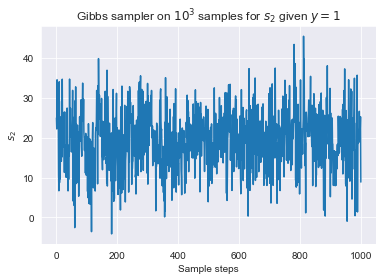

In [5]:
plt.plot(s2)
plt.title("Gibbs sampler on $10^3$ samples for $s_2$ given $y=1$")
plt.ylabel("$s_2$")
plt.xlabel("Sample steps")
if(save):
    plt.savefig("s2traceplotwithoutburnin.png")
np.mean(s1)

<Figure size 1080x1080 with 0 Axes>

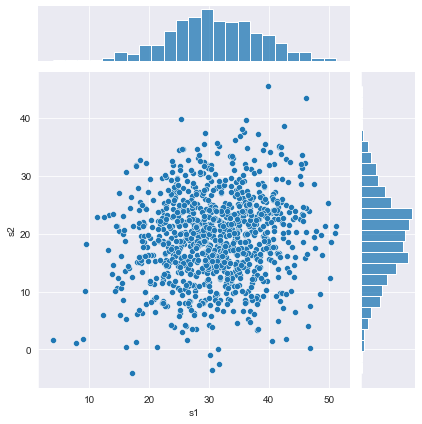

In [6]:
plt.figure(figsize=(15, 15))
sns.set_style("darkgrid")
sns.jointplot(data=experiment, x="s1", y="s2")

if(save):
    plt.savefig("s1s2jointplot.png")

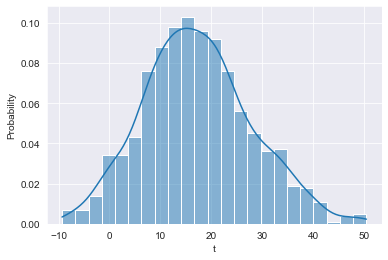

In [7]:
sns.histplot(experiment, x="t", kde=True, fill=True, stat='probability')
if(save):
    plt.savefig("thistogram.png")

### Trueskill representation of the skills

We will transform the samples into a gaussian. We will do this by approximating it as a gaussian.

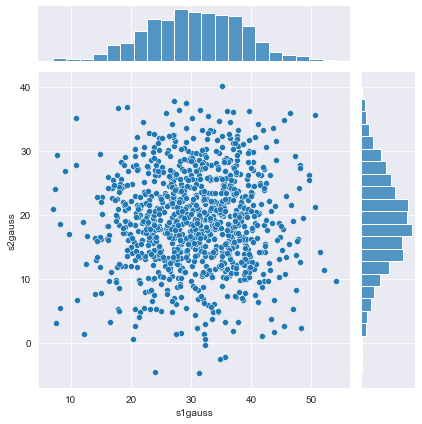

In [8]:
def gaussianApprox(samples):
    return scipy.stats.norm(loc=np.mean(samples), scale=np.std(samples))

s1gauss = gaussianApprox(experiment.s1)
s2gauss = gaussianApprox(experiment.s2)

approximation = pd.DataFrame(
    {
        "s1gauss" : s1gauss.rvs(L),
        "s2gauss" : s2gauss.rvs(L),
    }
)

sns.jointplot(data=approximation, x="s1gauss", y="s2gauss")

if(save):
    plt.savefig("GaussApproxJointPlot.png")

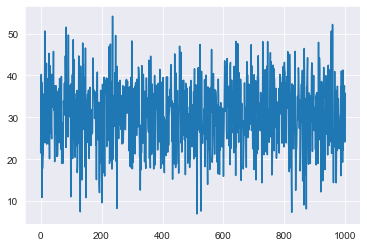

In [9]:
plt.plot(approximation.s1gauss)
if(save):
    plt.savefig("s1GaussApproxTraceplot.png")

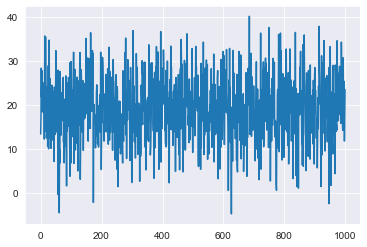

In [10]:
plt.plot(approximation.s2gauss)
if(save):
    plt.savefig("s1GaussApproxTraceplot.png")

### Plot histogram of samples with fitted gaussians $L=10^4$

In [11]:
# Samples
L = 10**4
burn = 50
# Priors
sigma_s = np.array([[(25/3)**2, 0], [0, (25/3)**2]])
mu_s = np.array([25, 25])

# Sample
s1, s2, t = gibbsSampler(L+burn, mu_s, sigma_s, burn)

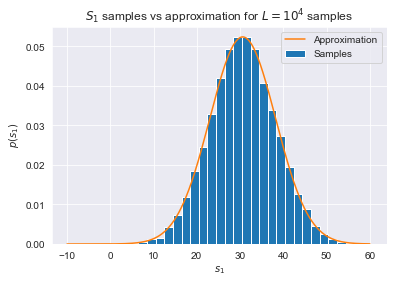

In [12]:
s1gauss = gaussianApprox(s1)
x  = np.linspace(-10,60, 1000)
plt.hist(s1, bins=30, density=True, label='Samples')
plt.plot(x, s1gauss.pdf(x), label='Approximation')
plt.xlabel("$s_1$")
plt.ylabel("$p(s_1)$")
plt.legend()
plt.title("$S_1$ samples vs approximation for $L =10^4$ samples")
if(save):
    plt.savefig("s1samplevsdist10000.png")

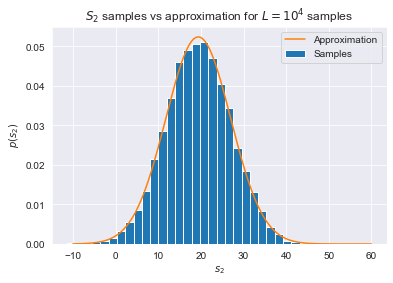

In [13]:
s2gauss = gaussianApprox(s2)
x  = np.linspace(-10,60, 1000)
plt.hist(s2, bins=30, density=True, label='Samples')
plt.plot(x, s2gauss.pdf(x), label='Approximation')
plt.xlabel("$s_2$")
plt.ylabel("$p(s_2)$")
plt.legend()
plt.title("$S_2$ samples vs approximation for $L =10^4$ samples")
if(save):
    plt.savefig("s2samplevsdist10000.png")

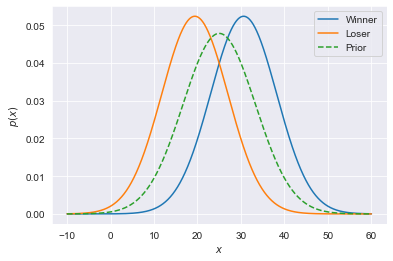

In [14]:
x  = np.linspace(-10,60, 1000)
plt.plot(x, s1gauss.pdf(x), label = 'Winner')
plt.plot(x, s2gauss.pdf(x), label = 'Loser')
plt.xlabel("$x$")
plt.ylabel("$p(x)$")
plt.plot(x, scipy.stats.norm.pdf(x, 25, 25/3), '--', label = 'Prior')
plt.legend()

### Plot histogram of samples with fitted gaussians $L=10^3$

In [15]:
# Samples
L = 10**3
burn = 50
# Priors
sigma_s = np.array([[(25/3)**2, 0], [0, (25/3)**2]])
mu_s = np.array([25, 25])

# Sample
s1, s2, t = gibbsSampler(L+burn, mu_s, sigma_s, burn)

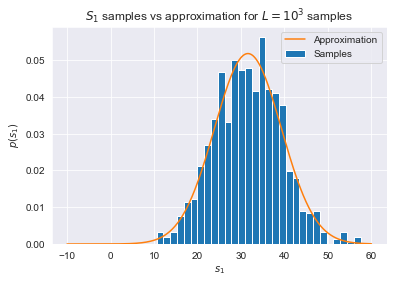

In [16]:
s1gauss = gaussianApprox(s1)
x  = np.linspace(-10,60, 1000)
plt.hist(s1, bins=30, density=True, label='Samples')
plt.plot(x, s1gauss.pdf(x), label='Approximation')
plt.xlabel("$s_1$")
plt.ylabel("$p(s_1)$")
plt.legend()
plt.title("$S_1$ samples vs approximation for $L =10^3$ samples")
if(save):
    plt.savefig("s1samplevsdist1000.png")

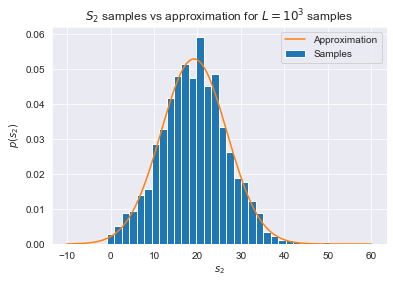

In [17]:
s2gauss = gaussianApprox(s2)
x  = np.linspace(-10,60, 1000)
plt.hist(s2, bins=30, density=True, label='Samples')
plt.plot(x, s2gauss.pdf(x), label='Approximation')
plt.xlabel("$s_2$")
plt.ylabel("$p(s_2)$")
plt.legend()
plt.title("$S_2$ samples vs approximation for $L =10^3$ samples")
if(save):
    plt.savefig("s2samplevsdist1000.png")

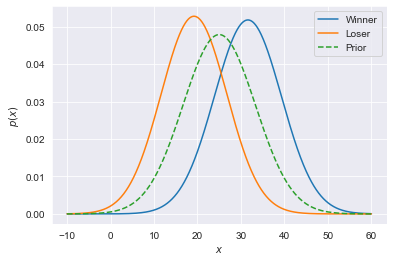

In [18]:
x  = np.linspace(-10,60, 1000)
plt.plot(x, s1gauss.pdf(x), label = 'Winner')
plt.plot(x, s2gauss.pdf(x), label = 'Loser')
plt.xlabel("$x$")
plt.ylabel("$p(x)$")
plt.plot(x, scipy.stats.norm.pdf(x, 25, 25/3), '--', label = 'Prior')
plt.legend()

### Plot histogram of samples with fitted gaussians $L=100$

In [19]:
# Samples
L = 100
burn = 50
# Priors
sigma_s = np.array([[(25/3)**2, 0], [0, (25/3)**2]])
mu_s = np.array([25, 25])

# Sample
s1, s2, t = gibbsSampler(L+burn, mu_s, sigma_s, burn)

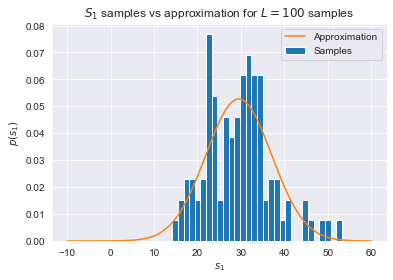

In [20]:
s1gauss = gaussianApprox(s1)
x  = np.linspace(-10,60, 1000)
plt.hist(s1, bins=30, density=True, label='Samples')
plt.plot(x, s1gauss.pdf(x), label='Approximation')
plt.xlabel("$s_1$")
plt.ylabel("$p(s_1)$")
plt.legend()
plt.title("$S_1$ samples vs approximation for $L =100$ samples")
if(save):
    plt.savefig("s1samplevsdist100.png")

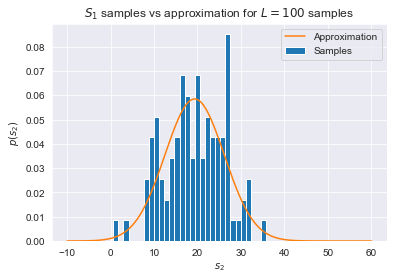

In [21]:
s2gauss = gaussianApprox(s2)
x  = np.linspace(-10,60, 1000)
plt.hist(s2, bins=30, density=True, label='Samples')
plt.plot(x, s2gauss.pdf(x), label='Approximation')
plt.xlabel("$s_2$")
plt.ylabel("$p(s_2)$")
plt.legend()
plt.title("$S_1$ samples vs approximation for $L =100$ samples")
if(save):
    plt.savefig("s2samplevsdist100.png")

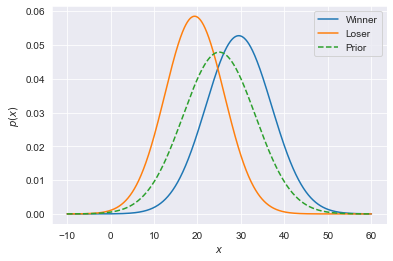

In [22]:
x  = np.linspace(-10,60, 1000)
plt.plot(x, s1gauss.pdf(x), label = 'Winner')
plt.plot(x, s2gauss.pdf(x), label = 'Loser')
plt.xlabel("$x$")
plt.ylabel("$p(x)$")
plt.plot(x, scipy.stats.norm.pdf(x, 25, 25/3), '--', label = 'Prior')
plt.legend()

### Plot histogram of samples with fitted gaussians $L=30$

In [23]:
# Samples
L = 30
burn = 50
# Priors
sigma_s = np.array([[(25/3)**2, 0], [0, (25/3)**2]])
mu_s = np.array([25, 25])

# Sample
s1, s2, t = gibbsSampler(L+burn, mu_s, sigma_s, burn)

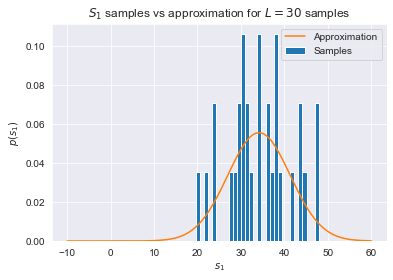

In [24]:
s1gauss = gaussianApprox(s1)
x  = np.linspace(-10,60, 1000)
plt.hist(s1, bins=30, density=True, label='Samples')
plt.plot(x, s1gauss.pdf(x), label='Approximation')
plt.xlabel("$s_1$")
plt.ylabel("$p(s_1)$")
plt.legend()
plt.title("$S_1$ samples vs approximation for $L =30$ samples")
if(save):
    plt.savefig("s1samplevsdist30.png")

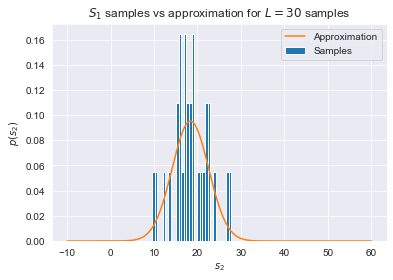

In [25]:
s2gauss = gaussianApprox(s2)
x  = np.linspace(-10,60, 1000)
plt.hist(s2, bins=30, density=True, label='Samples')
plt.plot(x, s2gauss.pdf(x), label='Approximation')
plt.xlabel("$s_2$")
plt.ylabel("$p(s_2)$")
plt.legend()
plt.title("$S_1$ samples vs approximation for $L =30$ samples")
if(save):
    plt.savefig("s2samplevsdist30.png")

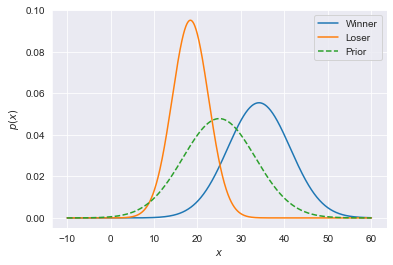

In [26]:
x  = np.linspace(-10,60, 1000)
plt.plot(x, s1gauss.pdf(x), label = 'Winner')
plt.plot(x, s2gauss.pdf(x), label = 'Loser')
plt.xlabel("$x$")
plt.ylabel("$p(x)$")
plt.plot(x, scipy.stats.norm.pdf(x, 25, 25/3), '--', label = 'Prior')
plt.legend()

### Compare priors with posteriors given thet $p(s|y=1)$

Our prior stated:

$$
p(s_1) = \sim N(s_1; 25, (25/3)^2)
$$

$$
p(s_2) = \sim N(s_2; 25, (25/3)^2)
$$

Empirically we have:

In [27]:
np.mean(s1)

34.145487388868986

In [28]:
np.var(s1)

51.64339598982203

In [29]:
np.mean(s2)

18.371195452949177

In [30]:
np.var(s2)

17.530637687165655

# Question 6

Use ADF with Gibbs sampling to process the matches in the SerieA dataset and estimatethe skill of all the teams in the dataset 

In [31]:
# Read the data
data = 'datasets/SerieA.csv'
shuffle = True
serieA = pd.read_csv(data)
cleaned = serieA[serieA['score1'] != serieA['score2']]
cleaned["pred"] = 0
cleaned['true'] = np.where(cleaned['score1'] > cleaned['score2'], 1, -1)
if(shuffle):
    cleaned = cleaned.sample(frac=1).reset_index(drop=True)
cleaned

<ipython-input-31-5396bc7565c3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned["pred"] = 0
<ipython-input-31-5396bc7565c3>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned['true'] = np.where(cleaned['score1'] > cleaned['score2'], 1, -1)


,yyyy-mm-dd,HH:MM,team1,team2,score1,score2,pred,true
0,2019-04-29,19:00,Atalanta,Udinese,2,0,0,1
1,2019-05-05,12:30,Empoli,Fiorentina,1,0,0,1
2,2019-04-07,12:30,Fiorentina,Frosinone,0,1,0,-1
3,2018-09-15,15:00,Inter,Parma,0,1,0,-1
4,2018-08-18,18:00,Chievo,Juventus,2,3,0,-1
...,...,...,...,...,...,...,...,...
267,2019-03-11,20:30,Roma,Empoli,2,1,0,1
268,2019-03-31,18:00,Bologna,Sassuolo,2,1,0,1
269,2019-03-10,15:00,Inter,Spal,2,0,0,1
270,2019-02-10,18:00,Sassuolo,Juventus,0,3,0,-1


## Add priors to all teams

In [32]:
# hyperparameters
L = 100
burn = 50
# Priors
sigma_s = np.array([[(25/3)**2, 0], [0,(25/3)**2]], dtype=np.float64)
mu_s = np.array([25, 25], dtype=np.float64)

# Sample
s1, s2, t = gibbsSampler(L+burn, mu_s, sigma_s, burn)
s1gauss = gaussianApprox(s1)
s2gauss = gaussianApprox(s2)
teams = cleaned.team1.unique()

# Make dictionary of priors
distributions = {}

# Give all same prior
for team in teams:
    distributions[team] = s1gauss

## Update distributions based on data

In [33]:
# Update priors based on data
for index, row in cleaned.iterrows():
    if row['score1'] > row['score2']:
        # Team 1 won
        mu1 = distributions[row['team1']].mean()
        mu2 = distributions[row['team2']].mean()
        s1 = distributions[row['team1']].var()
        s2 = distributions[row['team2']].var()

        mu_s = np.array([mu1, mu2], np.float64)
        sigma_s = np.array([[s1, 0], [0, s2]], dtype=np.float64)

        # Sample
        s1, s2, t = gibbsSampler(L+burn, mu_s, sigma_s, burn)
        s1gauss = gaussianApprox(s1)
        s2gauss = gaussianApprox(s2)
        distributions[row['team1']] = s1gauss
        distributions[row['team2']] = s2gauss

    else:
        # Team 2 won
        mu1 = distributions[row['team2']].mean()
        mu2 = distributions[row['team1']].mean()
        s1 = distributions[row['team2']].var()
        s2 = distributions[row['team1']].var()

        mu_s = np.array([mu1, mu2], np.float64)
        sigma_s = np.array([[s1, 0], [0, s2]], dtype=np.float64)

        # Sample
        s1, s2, t = gibbsSampler(L+burn, mu_s, sigma_s, burn)
        s1gauss = gaussianApprox(s1)
        s2gauss = gaussianApprox(s2)
        distributions[row['team2']] = s1gauss
        distributions[row['team1']] = s2gauss


## Create a ranking table that ranks based on trueskill's conservative skill with $k=3$

In [34]:
team, mu, std, cs = [], [], [], []
k = 3

for key, dist in distributions.items():
    team.append(key)
    mu.append(dist.mean())
    std.append(dist.std())
    cs.append(dist.mean() - k*dist.std())

results = pd.DataFrame(
    {
        'Team': team,
        'Mean' : mu,
        'Std' : std,
        'Conservative Skill': cs
    }
)
results = results.sort_values('Conservative Skill', ascending=False).reset_index(drop=True)
results

,Team,Mean,Std,Conservative Skill
0,Juventus,56.789404,1.566649,52.089457
1,Milan,50.350296,1.887449,44.687949
2,Atalanta,47.350071,1.909805,41.620657
3,Napoli,45.102737,1.661095,40.119451
4,Roma,44.101101,1.444509,39.767575
5,Inter,43.960440,1.462516,39.572893
6,Torino,40.943986,1.827481,35.461543
7,Lazio,38.868083,2.818654,30.412119
8,Empoli,29.882521,1.791423,24.508252
9,Sampdoria,27.439857,1.252338,23.682844


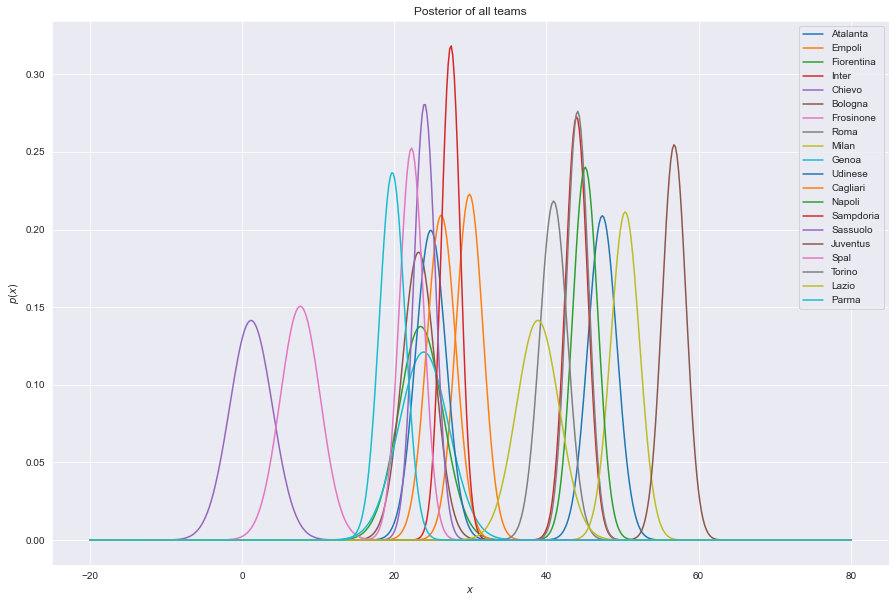

In [35]:
x = np.linspace(-20, 80, 500)

plt.figure(figsize=(15, 10))

for key, dist in distributions.items():
    plt.plot(x, dist.pdf(x), label=key)

plt.legend()
plt.title("Posterior of all teams")
plt.xlabel("$x$")
plt.ylabel("$p(x)$")
if(save):
    plt.savefig("posteriors.png")

## Q7 Using the model for predictions



In [36]:
def winningPrediction(player1, player2, k=3):
    m1, m2 = distributions[player1].mean(), distributions[player2].mean()
    s1, s2 = distributions[player1].std(), distributions[player2].std()
    cs1, cs2 = m1 - k*s1, m2 - k*s2
    if(cs1 >= cs2):
      return 1
    else:
      return -1

## Reset Priors

In [37]:
# hyperparameters
L = 100
burn = 50

# Priors
sigma_s = np.array([[(25/3)**2, 0], [0,(25/3)**2]], dtype=np.float64)
mu_s = np.array([25, 25], dtype=np.float64)


# Sample
s1, s2, t = gibbsSampler(L+burn, mu_s, sigma_s, burn)
s1gauss = gaussianApprox(s1)
s2gauss = gaussianApprox(s2)
teams = cleaned.team1.unique()

# Make dictionary of priors
distributions = {}

# Give all same prior
for team in teams:
    distributions[team] = s1gauss

## Calculate posterior and predict one step ahead

In [38]:
pred = []

# Update priors based on data
for index, row in cleaned.iterrows():
    if row['score1'] > row['score2']:
        # Team 1 won
        mu1 = distributions[row['team1']].mean()
        mu2 = distributions[row['team2']].mean()
        s1 = distributions[row['team1']].var()
        s2 = distributions[row['team2']].var()

        pred.append(winningPrediction(row['team1'], row['team2']))

        mu_s = np.array([mu1, mu2], np.float64)
        sigma_s = np.array([[s1, 0], [0, s2]], dtype=np.float64)

        # Sample
        s1, s2, t = gibbsSampler(L+burn, mu_s, sigma_s, burn)
        s1gauss = gaussianApprox(s1)
        s2gauss = gaussianApprox(s2)
        distributions[row['team1']] = s1gauss
        distributions[row['team2']] = s2gauss

    else:
        # Team 2 won
        mu1 = distributions[row['team2']].mean()
        mu2 = distributions[row['team1']].mean()
        s1 = distributions[row['team2']].var()
        s2 = distributions[row['team1']].var()

        pred.append(winningPrediction(row['team1'], row['team2']))

        mu_s = np.array([mu1, mu2], np.float64)
        sigma_s = np.array([[s1, 0], [0, s2]], dtype=np.float64)

        # Sample
        s1, s2, t = gibbsSampler(L+burn, mu_s, sigma_s, burn)
        s1gauss = gaussianApprox(s1)
        s2gauss = gaussianApprox(s2)
        distributions[row['team2']] = s1gauss
        distributions[row['team1']] = s2gauss

cleaned["pred"] = pred

In [39]:
true_values = np.array(cleaned.true)
predictions = np.array(cleaned.pred)
np.sum(true_values == predictions) / len(true_values)

0.6433823529411765

# Question 10. Tennis datasets

I have downloaded the tennis dataset from [ATP Wourld Tour tennis data](https://datahub.io/sports-data/atp-world-tour-tennis-data).
Let us explore this data and clean it up.

In [40]:
tennis = pd.read_csv('datasets/tennis.csv')

## Explore the features

In [41]:
tennis.columns

Index(['tourney_year_id', 'tourney_order', 'tourney_slug',
       'tourney_url_suffix', 'tourney_round_name', 'round_order',
       'match_order', 'winner_name', 'winner_player_id', 'winner_slug',
       'loser_name', 'loser_player_id', 'loser_slug', 'winner_seed',
       'loser_seed', 'match_score_tiebreaks', 'winner_sets_won',
       'loser_sets_won', 'winner_games_won', 'loser_games_won',
       'winner_tiebreaks_won', 'loser_tiebreaks_won', 'match_id',
       'match_stats_url_suffix'],
      dtype='object')

## Data Cleaning

In [42]:
# Hyperparameters
N = 15      # No of top winners we want to include
Y = 2015    # Start year (inclusive)

# Extract relevant features
features = ['tourney_year_id', 'winner_name', 'loser_name']
tennis = tennis[features]

if(tennis.tourney_year_id.dtype == 'object'):
    # convert to years  
    tennis['tourney_year_id'] = tennis['tourney_year_id'].apply(lambda x : x.split('-')[0])
    tennis['tourney_year_id'] = tennis['tourney_year_id'].astype(int)

# Extract the latest years
tennis = tennis[tennis.tourney_year_id >= Y]

# Extract the 15 players who won the most matches
winners = tennis.winner_name.value_counts()[:N].index.to_list()

# Extract matches where these players are playing eachother
topplayers = tennis[tennis.winner_name.isin(winners) & tennis.loser_name.isin(winners)]

# Add prediction column
topplayers["pred"] = 0

<ipython-input-42-68e940c14ff7>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topplayers["pred"] = 0


## Run Gibbs sampler on data

In [43]:
# hyperparameters
L = 100
burn = 50
# Priors
sigma_s = np.array([[(25/3)**2, 0], [0,(25/3)**2]], dtype=np.float64)
mu_s = np.array([25, 25], dtype=np.float64)
# Sample
s1, s2, t = gibbsSampler(L+burn, mu_s, sigma_s, burn)
s1gauss = gaussianApprox(s1)
s2gauss = gaussianApprox(s2)

# Make dictionary of priors
distributions = {}

# Give all same prior
for player in winners:
    distributions[player] = s1gauss

In [44]:
pred = []

# Update priors based on data
for index, row in topplayers.iterrows():
    pred.append(winningPrediction(row['winner_name'], row['loser_name']))
    mu1 = distributions[row['winner_name']].mean()
    mu2 = distributions[row['loser_name']].mean()
    s1 = distributions[row['winner_name']].var()
    s2 = distributions[row['loser_name']].var()

    mu_s = np.array([mu1, mu2], np.float64)
    sigma_s = np.array([[s1, 0], [0, s2]], dtype=np.float64)

    # Sample
    s1, s2, t = gibbsSampler(L+burn, mu_s, sigma_s, burn)
    s1gauss = gaussianApprox(s1)
    s2gauss = gaussianApprox(s2)
    distributions[row['winner_name']] = s1gauss
    distributions[row['loser_name']] = s2gauss

topplayers["pred"] = pred

<ipython-input-44-3b5b5e5b2047>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topplayers["pred"] = pred


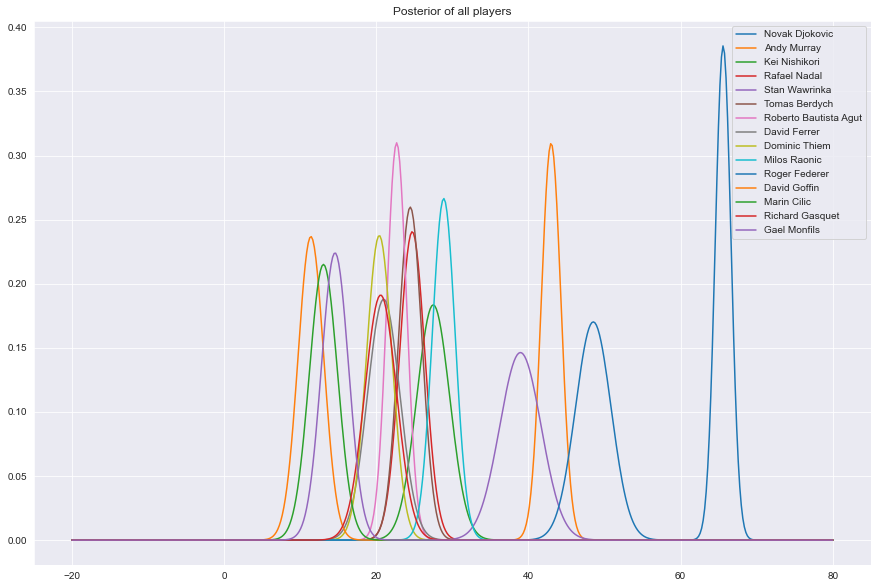

In [45]:
x = np.linspace(-20, 80, 500)

plt.figure(figsize=(15, 10))

for key, dist in distributions.items():
    plt.plot(x, dist.pdf(x), label=key)

plt.legend()
plt.title("Posterior of all players")
if(save):
    plt.savefig("posteriors.png")

In [46]:
team, cs = [], []
k = 3

for key, dist in distributions.items():
    team.append(key)
    cs.append(dist.mean() - k*dist.std())

results = pd.DataFrame(
    {
        'Team': team,
        'Conservative Skill': cs
    }
)
results = results.sort_values('Conservative Skill', ascending=False).reset_index(drop=True)
results

,Team,Conservative Skill
0,Novak Djokovic,62.489238
1,Roger Federer,41.496695
2,Andy Murray,39.118803
3,Stan Wawrinka,30.772023
4,Milos Raonic,24.380736
5,Kei Nishikori,20.972143
6,Tomas Berdych,19.863305
7,Rafael Nadal,19.756981
8,Roberto Bautista Agut,18.822697
9,Dominic Thiem,15.362603


In [47]:
predictions = np.array(topplayers['pred'])

print("Accuray: " + str(np.sum(predictions==1) / len(predictions)))

Accuray: 0.7127272727272728


## Q11 Extensions of model

Include draws:

In [48]:
def winningPrediction(player1, player2, k=3, drawprob=0.5):
    m1, m2 = distributions[player1].mean(), distributions[player2].mean()
    s1, s2 = distributions[player1].std(), distributions[player2].std()

    # Draw update
    beta = ((s1+s2)/4)**2
    margin = np.abs(mu1 - mu2)
    epsilon = scipy.stats.norm.ppf((drawprob + 1)/2)*np.sqrt(2)*beta

    # Check if inside draw margin.
    if(margin < epsilon):
      return 0

    cs1, cs2 = m1 - k*s1, m2 - k*s2
    if(cs1 >= cs2):
      return 1
    else:
      return -1

In [49]:
# Read the data
data = 'datasets/SerieA.csv'
shuffle = False
serieA = pd.read_csv(data)
cleaned = serieA
cleaned["pred"] = 0
cleaned['true'] = np.sign(cleaned['score1'] - cleaned['score2'])
if(shuffle):
    cleaned = cleaned.sample(frac=1).reset_index(drop=True)
cleaned

,yyyy-mm-dd,HH:MM,team1,team2,score1,score2,pred,true
0,2018-08-18,18:00,Chievo,Juventus,2,3,0,-1
1,2018-08-18,20:30,Lazio,Napoli,1,2,0,-1
2,2018-08-19,18:00,Torino,Roma,0,1,0,-1
3,2018-08-19,20:30,Sassuolo,Inter,1,0,0,1
4,2018-08-19,20:30,Parma,Udinese,2,2,0,0
...,...,...,...,...,...,...,...,...
375,2019-05-26,20:30,Roma,Parma,2,1,0,1
376,2019-05-26,20:30,Inter,Empoli,2,1,0,1
377,2019-05-26,20:30,Fiorentina,Genoa,0,0,0,0
378,2019-05-26,20:30,Cagliari,Udinese,1,2,0,-1


In [50]:
# hyperparameters
L = 100
burn = 50
# Priors
sigma_s = np.array([[(25/3)**2, 0], [0,(25/3)**2]], dtype=np.float64)
mu_s = np.array([25, 25], dtype=np.float64)


# Sample
s1, s2, t = gibbsSampler(L+burn, mu_s, sigma_s, burn)
s1gauss = gaussianApprox(s1)
s2gauss = gaussianApprox(s2)

# Make dictionary of priors
distributions = {}

# Give all same prior
for player in teams:
    distributions[player] = s1gauss

In [51]:
pred = []
drawprob = 0.5

# Update priors based on data
for index, row in cleaned.iterrows():
    if row['score1'] > row['score2']:
        # Team 1 won
        mu1 = distributions[row['team1']].mean()
        mu2 = distributions[row['team2']].mean()
        s1 = distributions[row['team1']].var()
        s2 = distributions[row['team2']].var()

        pred.append(winningPrediction(row['team1'], row['team2'], drawprob))

        mu_s = np.array([mu1, mu2], np.float64)
        sigma_s = np.array([[s1, 0], [0, s2]], dtype=np.float64)

        # Sample
        s1, s2, t = gibbsSampler(L+burn, mu_s, sigma_s, burn)
        s1gauss = gaussianApprox(s1)
        s2gauss = gaussianApprox(s2)
        distributions[row['team1']] = s1gauss
        distributions[row['team2']] = s2gauss

    elif row['score1'] < row['score2']:
        # Team 2 won
        mu1 = distributions[row['team2']].mean()
        mu2 = distributions[row['team1']].mean()
        s1 = distributions[row['team2']].var()
        s2 = distributions[row['team1']].var()

        pred.append(winningPrediction(row['team1'], row['team2'], drawprob))

        mu_s = np.array([mu1, mu2], np.float64)
        sigma_s = np.array([[s1, 0], [0, s2]], dtype=np.float64)

        # Sample
        s1, s2, t = gibbsSampler(L+burn, mu_s, sigma_s, burn)
        s1gauss = gaussianApprox(s1)
        s2gauss = gaussianApprox(s2)
        distributions[row['team2']] = s1gauss
        distributions[row['team1']] = s2gauss
    else:
        # We have a draw
        mu1 = distributions[row['team1']].mean()
        mu2 = distributions[row['team2']].mean()

        # NB: Standard deviation in this case
        s1 = distributions[row['team1']].std()
        s2 = distributions[row['team2']].std()

        pred.append(winningPrediction(row['team1'], row['team2'], drawprob))

        # Draw update
        beta = ((s1+s2)/4)**2
        margin = np.abs(mu1 - mu2)
        epsilon = scipy.stats.norm.ppf((drawprob + 1)/2)*np.sqrt(2)*beta

        # Check if inside draw margin.
        if(margin < epsilon):
            if(mu1 > mu2):
                # Punish player 1
                newmu1 = mu1 - margin/s1
                distributions[row['team1']] = scipy.stats.norm(loc=newmu1, scale=s1)
                # Reward player 2
                newmu2 = mu2 + margin/s2
                distributions[row['team1']] = scipy.stats.norm(loc=newmu2, scale=s2)
            if(mu2 > mu1):
                # Reward player 1
                newmu1 = mu1 + margin/s1
                distributions[row['team1']] = scipy.stats.norm(loc=newmu1, scale=s1)
                # Punish player 2
                newmu2 = mu2 - margin/s2
                distributions[row['team1']] = scipy.stats.norm(loc=newmu2, scale=s2)

cleaned["pred"] = pred

In [52]:
cleaned.pred.value_counts()

-1    150
 1    145
 0     85
Name: pred, dtype: int64

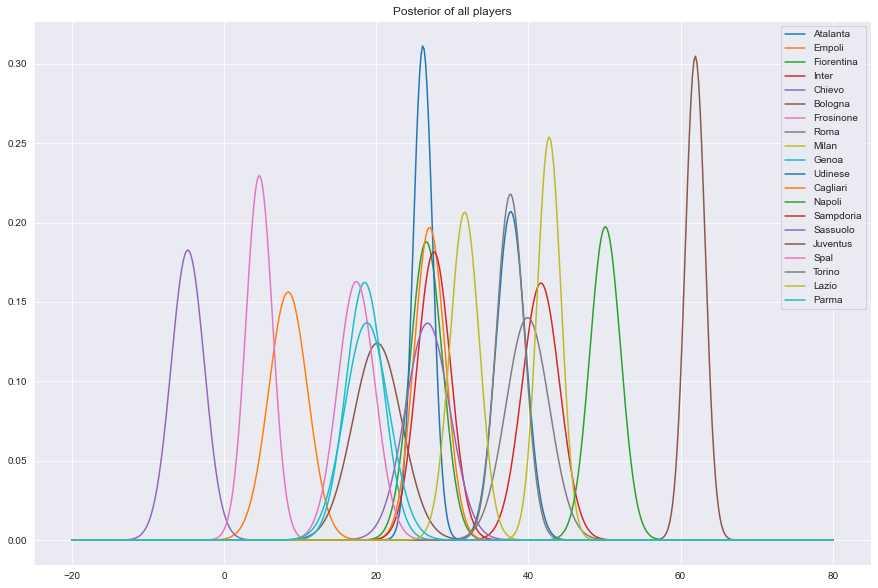

In [53]:
x = np.linspace(-20, 80, 500)

plt.figure(figsize=(15, 10))

for key, dist in distributions.items():
    plt.plot(x, dist.pdf(x), label=key)

plt.legend()
plt.title("Posterior of all players")
if(save):
    plt.savefig("posteriors.png")

true_values = np.array(cleaned.true)
predictions = np.array(cleaned.pred)

conf = confusion_matrix(true_values, predictions)

In [54]:
def recall(conf, classname):
    results = {}
    for key, value in classname.items():
        results[key] = conf[value, value] / np.sum(conf[value, :])
    return results

def precision(conf, classname):
    results = {}
    for key, value in classname.items():
        results[key] = conf[value, value] / np.sum(conf[:, value])
    return results

def f1(conf, classname):
    rec = recall(conf, classname)
    prec = precision(conf, classname)
    results = {}
    for key in rec:
        results[key] = (2*prec[key]*rec[key]) / (prec[key]+rec[key])
    return results

classname = {
    "Loss": 0,
    "Draw": 1,
    "Win": 2
} 

recall(conf, classname)

{'Loss': 0.6509433962264151,
 'Draw': 0.25925925925925924,
 'Win': 0.5240963855421686}

In [55]:
precision(conf, classname)

{'Loss': 0.46, 'Draw': 0.32941176470588235, 'Win': 0.6}

In [56]:
f1(conf, classname)

{'Loss': 0.5390625, 'Draw': 0.29015544041450775, 'Win': 0.5594855305466238}